In [85]:
# def read_yt_table(table_path, token=None):
#     """reads table from hahn, returns DF"""
#     yt.config["proxy"]["url"] = 'hahn.yt.yandex.net'
#     client = yt.YtClient(proxy='hahn', token=token)
#     read_result = client.read_table(table_path, raw=False)

#     raw_data = [row for row in read_result.rows]
#     return pd.DataFrame(raw_data)

In [89]:
import yt.wrapper as yt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu, ttest_ind
import os

from tqdm.auto import tqdm
from collections import Counter

%matplotlib inline

In [90]:
# from scipy.stats import permutation_test

In [91]:
yt.config["proxy"]["url"] = 'hahn.yt.yandex.net'
client = yt.YtClient(proxy='hahn', token=os.environ.get('YT_TOKEN'))

In [66]:
def calc_metric_avg(data, part_coef=0.8, test_name="test", portion=None, buckets=100, alpha=0.0, norm_column="probability"):
    
    flag = (data["test_name"] == test_name) & (data["stupid_cnt"] == 0) 
    
    if portion is not None:
        flag = flag & (data["portion"] == portion)
    
    nes_part = data[flag]
    
    frequency_norm = nes_part[norm_column].values / nes_part[norm_column].values.sum()
    
    norm = 1 * (1 - alpha) + alpha * frequency_norm * len(nes_part)
    
    raw_resulrs = norm * (nes_part["part_cnt"] * part_coef + nes_part["good_cnt"]) / (nes_part["part_cnt"] + nes_part["good_cnt"] + nes_part["bad_cnt"])
        
    bucket = nes_part["uuid"].apply(lambda x: hash(x) % buckets)
    
    pd_results = pd.DataFrame({
        "metric": raw_resulrs.values,
        "bucket": bucket.values
    })
    
    final_results = pd_results.groupby(by=["bucket"]).mean()["metric"].values
    
    return final_results

def calc_metric_energy(data, part_coef=0.8, test_name="test", portion=None, buckets=100, alpha=0.0, norm_column="probability"):
    
    flag = (data["test_name"] == test_name) & (data["stupid_cnt"] == 0) 
    
    if portion is not None:
        flag = flag & (data["portion"] == portion)
    
    nes_part = data[flag]
    
    frequency_norm = nes_part[norm_column].values / nes_part[norm_column].values.sum()
    
    norm = 1 * (1 - alpha) + alpha * frequency_norm * len(nes_part)
    
    raw_resulrs = norm * (nes_part["part_cnt"] * part_coef + nes_part["good_cnt"])
    
    bucket = nes_part["uuid"].apply(lambda x: hash(x) % buckets)
    
    pd_results = pd.DataFrame({
        "metric": raw_resulrs.values,
        "bucket": bucket.values
    })
    
    final_results = pd_results.groupby(by=["bucket"]).mean()["metric"].values
    
    return final_results

def calc_metric_raw_avg(data, part_coef=0.8, test_name="test", portion=None, buckets=100, alpha=0.0, norm_column="probability"):
    
    flag = (data["test_name"] == test_name)
    
    if portion is not None:
        flag = flag & (data["portion"] == portion)
    
    nes_part = data[flag]
    
    bucket = nes_part["uuid"].apply(lambda x: hash(x) % buckets).values
    
    final_buckets = np.concatenate(
        (
            np.repeat(bucket, nes_part["part_cnt"].values), 
            np.repeat(bucket, nes_part["good_cnt"].values), 
            np.repeat(bucket, nes_part["bad_cnt"].values)
        )
    )
    
    raw_resulrs = np.concatenate(
        (
            np.ones(nes_part["part_cnt"].values.sum()) * part_coef, 
            np.ones(nes_part["good_cnt"].values.sum()), 
            np.zeros(nes_part["bad_cnt"].values.sum())
        )
    )
    
    
    pd_results = pd.DataFrame({
        "metric": raw_resulrs,
        "bucket": final_buckets
    })
    
    final_results = pd_results.groupby(by=["bucket"]).mean()["metric"].values
    
    return final_results



# def process_exp(table_name, portion=None, calc_metric=calc_metric_avg, alpha=0.0, plot=True, norm_column="probability"):
#     read_result = pd.DataFrame(client.read_table(table_name, raw=False))
#     read_result["is_part"] = 1 * (read_result["result"] == "part")
#     read_result["is_stupid"] = 1 * (read_result["result"] == "stupid")
#     read_result["is_good"] = 1 * (read_result["result"] == "good")
#     read_result["is_bad"] = 1 * (read_result["result"] == "bad")
    
    
#     parsed_data = read_result.groupby(by=["session_id_old"]).agg(
#                                                     part_cnt = pd.NamedAgg(column = 'is_part', aggfunc = 'sum'),
#                                                     stupid_cnt = pd.NamedAgg(column = 'is_stupid', aggfunc = 'sum'),
#                                                     good_cnt = pd.NamedAgg(column = 'is_good', aggfunc = 'sum'),
#                                                     bad_cnt = pd.NamedAgg(column = 'is_bad', aggfunc = 'sum'),
#                                                     test_name = pd.NamedAgg(column = 'test_name', aggfunc = 'last'),
#                                                     uuid = pd.NamedAgg(column = 'uuid', aggfunc = 'last'),
#                                                     portion = pd.NamedAgg(column = 'portion', aggfunc = 'last'),
#                                                     frequency = pd.NamedAgg(column = 'frequency', aggfunc = 'mean'),
#                                                     session_len = pd.NamedAgg(column = 'session_len', aggfunc = 'last'),
#                                                     ).reset_index()
    
    
#     frequency = parsed_data.groupby(by=["test_name", "session_len", "portion"]).agg(
#         frequency = pd.NamedAgg(column = 'frequency', aggfunc = 'last'),
#     ).reset_index()

#     frequency_norm = frequency.groupby(by=["test_name", "portion"])["frequency"].sum().reset_index()

#     frequency = frequency.merge(frequency_norm, on=["test_name", "portion"], suffixes=("", "_norm"))
#     frequency["probability"] = frequency["frequency"]/frequency["frequency_norm"]
#     frequency.drop(columns=["frequency", "frequency_norm"], inplace=True)

#     parsed_data = parsed_data.merge(frequency, on=["test_name", "session_len", "portion"])

#     sessions_length = parsed_data.groupby(by=["test_name", "portion"])["session_len"].sum().reset_index()
#     parsed_data = parsed_data.merge(sessions_length, on=["test_name", "portion"],suffixes=("", "_norm"))
#     parsed_data["normalized_len"] = parsed_data["session_len"]/parsed_data["session_len_norm"]
    
#     test_raw = calc_metric(parsed_data, part_coef=0.5, test_name="test", portion=portion, alpha=alpha, norm_column=norm_column)
#     ctrl_raw = calc_metric(parsed_data, part_coef=0.5, test_name="ctrl", portion=portion, alpha=alpha, norm_column=norm_column)
    
    
#     pvalue=mannwhitneyu(ctrl_raw, test_raw).pvalue
#     effect = (test_raw.mean() - ctrl_raw.mean())/ctrl_raw.mean()
#     message = f'pvalue={pvalue:.3f}, effect={effect:.3f}, ctrl metric = {ctrl_raw.mean():.3f}, test_metric = {test_raw.mean():.3f}, cnt = {len(ctrl_raw) + len(test_raw)}'
#     #, pvalue, effect, ctrl_metric.mean(), test_metric.mean()
#     if plot:
#         print(message)
#         print()
    
#     res_dict={"p_value": pvalue, "cntr_value": ctrl_raw.mean(), "test_value": test_raw.mean()}
    
#     coefs = np.linspace(0, 1.0, 50)

    
#     if plot:
#         p_values = []

#         for coef in coefs:
#             test_raw = calc_metric(parsed_data, part_coef=coef, test_name="test", portion=portion)
#             ctrl_raw = calc_metric(parsed_data, part_coef=coef, test_name="ctrl", portion=portion)
#             pvalue=mannwhitneyu(ctrl_raw, test_raw).pvalue
#             p_values.append(pvalue)

#         plt.plot(coefs, p_values)
#         plt.show()
    
#     return res_dict

def process_exp(table_name, 
                portion=None, 
                calc_metric=calc_metric_avg, 
                alpha=0.0, 
                plot=True, 
                norm_column="probability", 
                beta=1000.0,
                test_name="test",
                cntrl_name="cntrl",
                probability_threshold=0.
            ):
    read_result = pd.DataFrame(client.read_table(table_name, raw=False))
    read_result["is_part"] = 1 * (read_result["result"] == "part")
    read_result["is_stupid"] = 1 * (read_result["result"] == "stupid")
    read_result["is_good"] = 1 * (read_result["result"] == "good")
    read_result["is_bad"] = 1 * (read_result["result"] == "bad")
    read_result = read_result[read_result["probability"] >= probability_threshold].reset_index(drop=True)
    
    
    parsed_data = read_result.groupby(by=["session_id_old"]).agg(
                                                    part_cnt = pd.NamedAgg(column = 'is_part', aggfunc = 'sum'),
                                                    stupid_cnt = pd.NamedAgg(column = 'is_stupid', aggfunc = 'sum'),
                                                    good_cnt = pd.NamedAgg(column = 'is_good', aggfunc = 'sum'),
                                                    bad_cnt = pd.NamedAgg(column = 'is_bad', aggfunc = 'sum'),
                                                    test_name = pd.NamedAgg(column = 'test_name', aggfunc = 'last'),
                                                    uuid = pd.NamedAgg(column = 'uuid', aggfunc = 'last'),
                                                    portion = pd.NamedAgg(column = 'portion', aggfunc = 'last'),
                                                    frequency = pd.NamedAgg(column = 'frequency', aggfunc = 'mean'),
                                                    session_len = pd.NamedAgg(column = 'session_len', aggfunc = 'last'),
                                                    ).reset_index()
    frequency = parsed_data.groupby(by=["test_name", "session_len", "portion"]).agg(
        frequency = pd.NamedAgg(column = 'frequency', aggfunc = 'last'),
    ).reset_index()

    frequency_norm = frequency.groupby(by=["test_name", "portion"])["frequency"].sum().reset_index()

    frequency = frequency.merge(frequency_norm, on=["test_name", "portion"], suffixes=("", "_norm"))
    frequency["probability"] = frequency["frequency"]/frequency["frequency_norm"]
    frequency.drop(columns=["frequency", "frequency_norm"], inplace=True)

    parsed_data = parsed_data.merge(frequency, on=["test_name", "session_len", "portion"])

    sessions_length = parsed_data.groupby(by=["test_name", "portion"])["session_len"].sum().reset_index()
    parsed_data = parsed_data.merge(sessions_length, on=["test_name", "portion"],suffixes=("", "_norm"))
    parsed_data["normalized_len"] = parsed_data["session_len"]/parsed_data["session_len_norm"]
    
    prob = np.random.uniform(size=len(parsed_data))
    
    parsed_data = parsed_data[prob < beta * parsed_data["probability"]].reset_index(drop=True)
    
    
    
    test_raw = calc_metric(parsed_data, part_coef=0.5, test_name=test_name, portion=portion, alpha=alpha, norm_column=norm_column)
    ctrl_raw = calc_metric(parsed_data, part_coef=0.5, test_name=cntrl_name, portion=portion, alpha=alpha, norm_column=norm_column)
    
    
    pvalue=mannwhitneyu(ctrl_raw, test_raw).pvalue
    effect = (test_raw.mean() - ctrl_raw.mean())/ctrl_raw.mean()
    message = f'pvalue={pvalue:.3f}, effect={effect:.3f}, ctrl metric = {ctrl_raw.mean():.3f}, test_metric = {test_raw.mean():.3f}, cnt = {len(ctrl_raw) + len(test_raw)}'
    #, pvalue, effect, ctrl_metric.mean(), test_metric.mean()
    if plot:
        print(message)
        print()
    
    res_dict={"p_value": pvalue, "cntr_value": ctrl_raw.mean(), "test_value": test_raw.mean()}
    
    coefs = np.linspace(0, 1.0, 50)

    
    if plot:
        p_values = []

        for coef in coefs:
            test_raw = calc_metric(parsed_data, part_coef=coef, test_name=test_name, portion=portion)
            ctrl_raw = calc_metric(parsed_data, part_coef=coef, test_name=cntrl_name, portion=portion)
            pvalue=mannwhitneyu(ctrl_raw, test_raw).pvalue
            p_values.append(pvalue)

        plt.plot(coefs, p_values)
        plt.show()
    
    return res_dict


def make_report_table_for_exp(table, test_name="test",
                cntrl_name="ctrl"):
    
    read_result = pd.DataFrame(client.read_table(table, raw=False))
    
    agreement = read_result["probability"].values.mean()
    
    res_metric_avg_without_weights_and_sampling = process_exp(table,
                                                            portion=None, 
                                                            plot=False,
                                                            calc_metric=calc_metric_avg,
                                                            test_name=test_name,
                                                            cntrl_name=cntrl_name 
                                                             )
    
    res_metric_avg_with_weights_and_sampling = process_exp( table,
                                                            portion=None, 
                                                            calc_metric=calc_metric_avg, 
                                                            plot=False,
                                                            alpha=1,
                                                            test_name=test_name,
                                                            cntrl_name=cntrl_name 
                                                          )
    
    res_metric_avg_without_weights_and_with_sampling = process_exp(table,
                                                                   portion=None, 
                                                                   calc_metric=calc_metric_avg,
                                                                   plot=False,
                                                                   beta=6,
                                                                   test_name=test_name,
                                                            cntrl_name=cntrl_name 
                                                                  )
    
    res_metric_raw_avg_without_weights_and_sampling = process_exp(table,
                                                                  portion=None, 
                                                                  plot=False,
                                                                  calc_metric=calc_metric_raw_avg,
                                                                  test_name=test_name,
                                                            cntrl_name=cntrl_name 
                                                                 )
    
    
    res_metric_raw_avg_without_weights_and_with_sampling = process_exp( table,
                                                                        portion=None, 
                                                                        plot=False,
                                                                        calc_metric=calc_metric_raw_avg,
                                                                        beta=6,
                                                                       test_name=test_name,
                                                            cntrl_name=cntrl_name 
                                                                      )
    
    res_metric_energy_without_weights_and_sampling = process_exp(table,
                                                                 portion=None, 
                                                                 plot=False,
                                                                 calc_metric=calc_metric_energy,
                                                                 test_name=test_name,
                                                            cntrl_name=cntrl_name 
                                                                )
    
    res_metric_energy_with_weights_and_sampling = process_exp(table,
                                                              portion=None, 
                                                              calc_metric=calc_metric_energy, 
                                                              plot=False,
                                                              alpha=1,
                                                              test_name=test_name,
                                                            cntrl_name=cntrl_name 
                                                             )
    
    res_metric_energy_without_weights_and_with_sampling = process_exp(table,
                                                                    portion=None, 
                                                                    calc_metric=calc_metric_energy,
                                                                    plot=False,
                                                                    beta=6,
                                                                      test_name=test_name,
                                                            cntrl_name=cntrl_name 
                                                                     )
    
    results = pd.DataFrame([
        {
            "metric": "Усреднеенная метрика по сессиям",
            "cntrl_value": res_metric_avg_without_weights_and_sampling["cntr_value"],
            "test_value": res_metric_avg_without_weights_and_sampling["test_value"],
            "diff": res_metric_avg_without_weights_and_sampling["test_value"] - res_metric_avg_without_weights_and_sampling["cntr_value"],
            "p_value": res_metric_avg_without_weights_and_sampling["p_value"],
        
        },
        
        {
            "metric": "Усреднеенная метрика по сессиям с взвешиванием",
            "cntrl_value": res_metric_avg_with_weights_and_sampling["cntr_value"],
            "test_value": res_metric_avg_with_weights_and_sampling["test_value"],
            "diff": res_metric_avg_with_weights_and_sampling["test_value"] - res_metric_avg_with_weights_and_sampling["cntr_value"],
            "p_value": res_metric_avg_with_weights_and_sampling["p_value"],
        
        },
        
        {
            "metric": "Усреднеенная метрика по сессиям с семплированием",
            "cntrl_value": res_metric_avg_without_weights_and_with_sampling["cntr_value"],
            "test_value": res_metric_avg_without_weights_and_with_sampling["test_value"],
            "diff": res_metric_avg_without_weights_and_with_sampling["test_value"] - res_metric_avg_without_weights_and_with_sampling["cntr_value"],
            "p_value": res_metric_avg_without_weights_and_with_sampling["p_value"],
        
        },
        
        {
            "metric": "Усреднеенная метрика по микро сессиям",
            "cntrl_value": res_metric_raw_avg_without_weights_and_sampling["cntr_value"],
            "test_value": res_metric_raw_avg_without_weights_and_sampling["test_value"],
            "diff": res_metric_raw_avg_without_weights_and_sampling["test_value"] - res_metric_raw_avg_without_weights_and_sampling["cntr_value"],
            "p_value": res_metric_raw_avg_without_weights_and_sampling["p_value"],
        
        },
        
        {
            "metric": "Усреднеенная метрика по микро сессиям с взвешиванием",
            "cntrl_value": res_metric_raw_avg_without_weights_and_with_sampling["cntr_value"],
            "test_value": res_metric_raw_avg_without_weights_and_with_sampling["test_value"],
            "diff": res_metric_raw_avg_without_weights_and_with_sampling["test_value"] - res_metric_raw_avg_without_weights_and_with_sampling["cntr_value"],
            "p_value": res_metric_raw_avg_without_weights_and_with_sampling["p_value"],
        
        },
        
        {
            "metric": "Средняя энергия сессий",
            "cntrl_value": res_metric_energy_without_weights_and_sampling["cntr_value"],
            "test_value": res_metric_energy_without_weights_and_sampling["test_value"],
            "diff": res_metric_energy_without_weights_and_sampling["test_value"] - res_metric_energy_without_weights_and_sampling["cntr_value"],
            "p_value": res_metric_energy_without_weights_and_sampling["p_value"],
        
        },
        
        {
            "metric": "Средняя энергия сессий с взвешиванием",
            "cntrl_value": res_metric_energy_with_weights_and_sampling["cntr_value"],
            "test_value": res_metric_energy_with_weights_and_sampling["test_value"],
            "diff": res_metric_energy_with_weights_and_sampling["test_value"] - res_metric_energy_with_weights_and_sampling["cntr_value"],
            "p_value": res_metric_energy_with_weights_and_sampling["p_value"],
        
        },
        
        {
            "metric": "Средняя энергия сессий с семплированием",
            "cntrl_value": res_metric_energy_without_weights_and_with_sampling["cntr_value"],
            "test_value": res_metric_energy_without_weights_and_with_sampling["test_value"],
            "diff": res_metric_energy_without_weights_and_with_sampling["test_value"] - res_metric_energy_without_weights_and_with_sampling["cntr_value"],
            "p_value": res_metric_energy_without_weights_and_with_sampling["p_value"],
        
        },
        {
            "metric": "Согласованность",
            "cntrl_value": agreement,
            "test_value": None,
            "diff": None,
            "p_value": None,
        
        },
    ])
    
    return results

def make_report_table_for_exp_without_sampl(table, test_name="test",
                cntrl_name="ctrl"):
    
    read_result = pd.DataFrame(client.read_table(table, raw=False))
    
    agreement = read_result["probability"].values.mean()
    
    res_metric_avg_without_weights_and_sampling = process_exp(table,
                                                            portion=None, 
                                                            plot=False,
                                                            calc_metric=calc_metric_avg,
                                                            test_name=test_name,
                                                            cntrl_name=cntrl_name 
                                                             )
    
    
    res_metric_raw_avg_without_weights_and_sampling = process_exp(table,
                                                                  portion=None, 
                                                                  plot=False,
                                                                  calc_metric=calc_metric_raw_avg,
                                                                  test_name=test_name,
                                                            cntrl_name=cntrl_name 
                                                                 )
    
    
    
    res_metric_energy_without_weights_and_sampling = process_exp(table,
                                                                 portion=None, 
                                                                 plot=False,
                                                                 calc_metric=calc_metric_energy,
                                                                 test_name=test_name,
                                                            cntrl_name=cntrl_name 
                                                                )
    

    
    results = pd.DataFrame([
        {
            "metric": "Усреднеенная метрика по сессиям",
            "cntrl_value": res_metric_avg_without_weights_and_sampling["cntr_value"],
            "test_value": res_metric_avg_without_weights_and_sampling["test_value"],
            "diff": res_metric_avg_without_weights_and_sampling["test_value"] - res_metric_avg_without_weights_and_sampling["cntr_value"],
            "p_value": res_metric_avg_without_weights_and_sampling["p_value"],
        
        },
        
        {
            "metric": "Усреднеенная метрика по микро сессиям",
            "cntrl_value": res_metric_raw_avg_without_weights_and_sampling["cntr_value"],
            "test_value": res_metric_raw_avg_without_weights_and_sampling["test_value"],
            "diff": res_metric_raw_avg_without_weights_and_sampling["test_value"] - res_metric_raw_avg_without_weights_and_sampling["cntr_value"],
            "p_value": res_metric_raw_avg_without_weights_and_sampling["p_value"],
        
        },
        
        {
            "metric": "Средняя энергия сессий",
            "cntrl_value": res_metric_energy_without_weights_and_sampling["cntr_value"],
            "test_value": res_metric_energy_without_weights_and_sampling["test_value"],
            "diff": res_metric_energy_without_weights_and_sampling["test_value"] - res_metric_energy_without_weights_and_sampling["cntr_value"],
            "p_value": res_metric_energy_without_weights_and_sampling["p_value"],
        
        },
        {
            "metric": "Согласованность",
            "cntrl_value": agreement,
            "test_value": None,
            "diff": None,
            "p_value": None,
        
        },
    ])
    
    return results

# Постклассификатор

In [90]:
process_exp('//home/voice/ilnur/tasks/EXPERIMENTS-75877/assessor_output_3-15_mv_with_test_name_4_portions',
            portion=None, 
            calc_metric=calc_metric_avg);

KeyError: 'probability'

pvalue=0.995, effect=0.011, ctrl metric = 0.643, test_metric = 0.650, cnt = 66



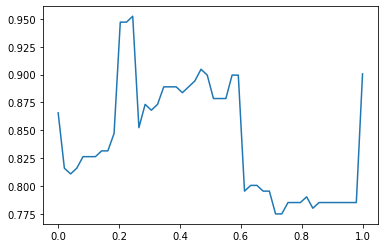

In [260]:
process_exp('//home/voice/ilnur/tasks/EXPERIMENTS-75877/assessor_output_3-15_mv_with_test_name_4_portions',
            portion=None, 
            calc_metric=calc_metric_avg, beta=1);

  0%|          | 0/20 [00:00<?, ?it/s]

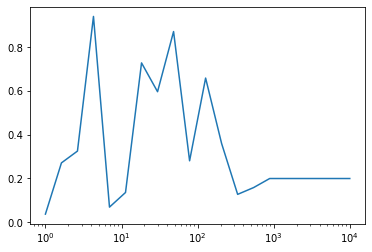

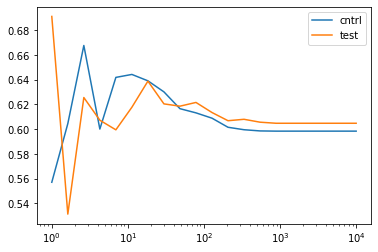

In [261]:
betas = np.logspace(0, 4, 20)
p_values = []
cntrl_metric = []
test_metric = []

for beta in tqdm(betas):
    res = process_exp('//home/voice/ilnur/tasks/EXPERIMENTS-75877/assessor_output_3-15_mv_with_test_name_4_portions', 
                      portion=None, calc_metric=calc_metric_avg, alpha=0, plot=False, beta=beta)
    
    p_values.append(res["p_value"])
    cntrl_metric.append(res["cntr_value"])
    test_metric.append(res["test_value"])
    
plt.plot(betas, p_values)
plt.xscale("log")
plt.show()

plt.plot(betas, cntrl_metric, label="cntrl")
plt.plot(betas, test_metric, label="test")
plt.xscale("log")
plt.legend()
plt.show()

pvalue=0.976, effect=-0.013, ctrl metric = 0.633, test_metric = 0.625, cnt = 200



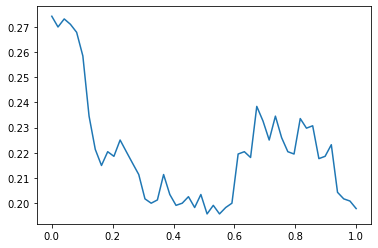

In [216]:
process_exp('//home/voice/ilnur/tasks/EXPERIMENTS-75877/assessor_output_3-15_mv_with_test_name_4_portions', 
            portion=None, 
            calc_metric=calc_metric_avg, 
            alpha=1.0);

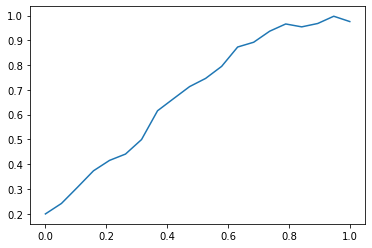

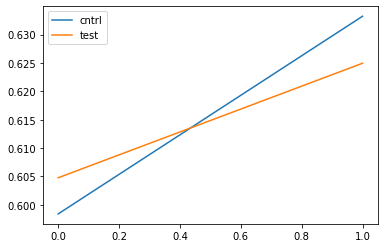

In [217]:
alphas = np.linspace(0, 1.0, 20)
p_values = []
cntrl_metric = []
test_metric = []

for alpha in alphas:
    res = process_exp('//home/voice/ilnur/tasks/EXPERIMENTS-75877/assessor_output_3-15_mv_with_test_name_4_portions', portion=None, calc_metric=calc_metric_avg, alpha=alpha, plot=False)
    
    p_values.append(res["p_value"])
    cntrl_metric.append(res["cntr_value"])
    test_metric.append(res["test_value"])
    
plt.plot(alphas, p_values)
plt.show()

plt.plot(alphas, cntrl_metric, label="cntrl")
plt.plot(alphas, test_metric, label="test")
plt.legend()
plt.show()

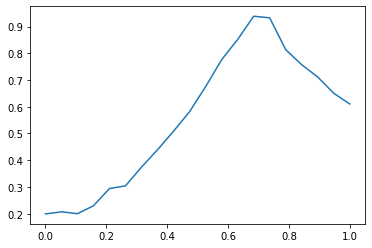

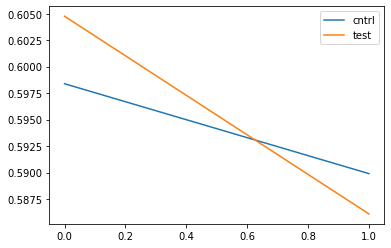

In [218]:
alphas = np.linspace(0, 1.0, 20)
p_values = []
cntrl_metric = []
test_metric = []

for alpha in alphas:
    res = process_exp('//home/voice/ilnur/tasks/EXPERIMENTS-75877/assessor_output_3-15_mv_with_test_name_4_portions', portion=None, calc_metric=calc_metric_avg, alpha=alpha, plot=False, norm_column="normalized_len")
    
    p_values.append(res["p_value"])
    cntrl_metric.append(res["cntr_value"])
    test_metric.append(res["test_value"])
    
plt.plot(alphas, p_values)
plt.show()

plt.plot(alphas, cntrl_metric, label="cntrl")
plt.plot(alphas, test_metric, label="test")
plt.legend()
plt.show()

pvalue=0.859, effect=-0.000, ctrl metric = 0.594, test_metric = 0.594, cnt = 200



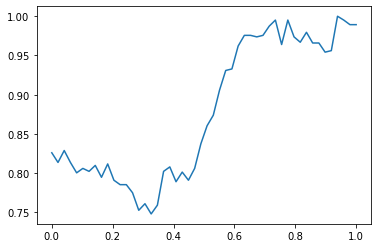

{'p_value': 0.859392854796376,
 'cntr_value': 0.5943020775451328,
 'test_value': 0.5941675662656759}

In [219]:
process_exp('//home/voice/ilnur/tasks/EXPERIMENTS-75877/assessor_output_3-15_mv_with_test_name_4_portions', 
            portion=None, calc_metric=calc_metric_raw_avg)

pvalue=0.004, effect=-0.044, ctrl metric = 1.020, test_metric = 0.975, cnt = 200



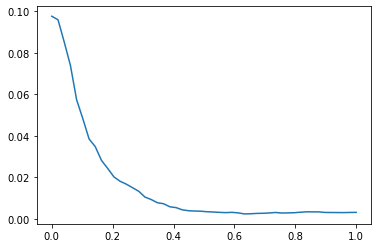

{'p_value': 0.0036257218201340416,
 'cntr_value': 1.0202040212147654,
 'test_value': 0.9753184893960705}

In [220]:
process_exp('//home/voice/ilnur/tasks/EXPERIMENTS-75877/assessor_output_3-15_mv_with_test_name_4_portions', 
            portion=None, calc_metric=calc_metric_energy
           )

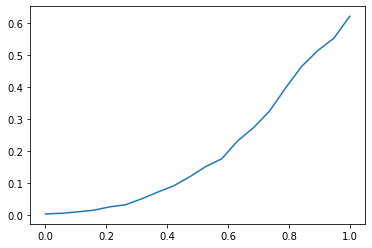

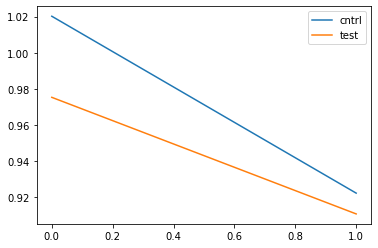

In [159]:
alphas = np.linspace(0, 1.0, 20)
p_values = []
cntrl_metric = []
test_metric = []

for alpha in alphas:
    res = process_exp('//home/voice/ilnur/tasks/EXPERIMENTS-75877/assessor_output_3-15_mv_with_test_name_4_portions', portion=None, calc_metric=calc_metric_energy, alpha=alpha, plot=False)
    
    p_values.append(res["p_value"])
    cntrl_metric.append(res["cntr_value"])
    test_metric.append(res["test_value"])
    
plt.plot(alphas, p_values)
plt.show()

plt.plot(alphas, cntrl_metric, label="cntrl")
plt.plot(alphas, test_metric, label="test")
plt.legend()
plt.show()

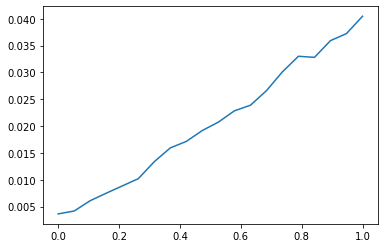

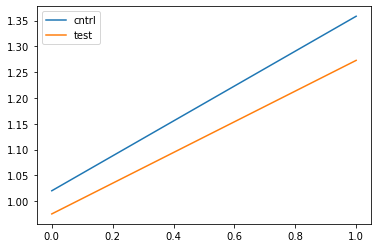

In [221]:
alphas = np.linspace(0, 1.0, 20)
p_values = []
cntrl_metric = []
test_metric = []

for alpha in alphas:
    res = process_exp('//home/voice/ilnur/tasks/EXPERIMENTS-75877/assessor_output_3-15_mv_with_test_name_4_portions', portion=None, calc_metric=calc_metric_energy, alpha=alpha, plot=False, norm_column="normalized_len")
    
    p_values.append(res["p_value"])
    cntrl_metric.append(res["cntr_value"])
    test_metric.append(res["test_value"])
    
plt.plot(alphas, p_values)
plt.show()

plt.plot(alphas, cntrl_metric, label="cntrl")
plt.plot(alphas, test_metric, label="test")
plt.legend()
plt.show()

In [275]:
res = make_report_table_for_exp('//home/voice/ilnur/tasks/EXPERIMENTS-75877/assessor_output_3-15_mv_with_test_name_4_portions')
res.to_csv("Постклассификатор")
res

,metric,cntrl_value,test_value,diff,p_value
0,Усреднеенная метрика по сессиям,0.598388,0.604757,0.006370,0.199141
1,Усреднеенная метрика по сессиям с взвешиванием,0.633228,0.624941,-0.008287,0.975635
2,Усреднеенная метрика по сессиям с семплированием,0.634931,0.639570,0.004639,0.983773
3,Усреднеенная метрика по микро сессиям,0.594302,0.594168,-0.000135,0.859393
4,Усреднеенная метрика по микро сессиям с взвеши...,0.610169,0.629798,0.019628,0.425836
5,Средняя энергия сессий,1.020204,0.975318,-0.044886,0.003626
6,Средняя энергия сессий с взвешиванием,1.024300,0.959758,-0.064542,0.036370
7,Средняя энергия сессий с семплированием,1.036919,0.990900,-0.046019,0.139004


# Отключение BERT

In [114]:
# //home/voice/ilnur/tasks/EXPERIMENTS-73207/extract_result_2_portions

pvalue=0.072, effect=0.038, ctrl metric = 0.506, test_metric = 0.525, cnt = 200



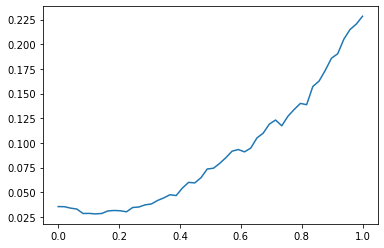

In [222]:
process_exp('//home/voice/ilnur/tasks/EXPERIMENTS-73207/extract_result_2_portions', portion=None, calc_metric=calc_metric_avg, alpha=0.0);

pvalue=0.363, effect=0.175, ctrl metric = 0.433, test_metric = 0.509, cnt = 32



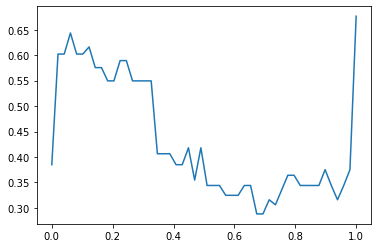

{'p_value': 0.3634619762558722,
 'cntr_value': 0.4333333333333333,
 'test_value': 0.5092105263157894}

In [263]:
process_exp('//home/voice/ilnur/tasks/EXPERIMENTS-73207/extract_result_2_portions', 
                      portion=None, calc_metric=calc_metric_avg, alpha=0, beta=1)

  0%|          | 0/20 [00:00<?, ?it/s]

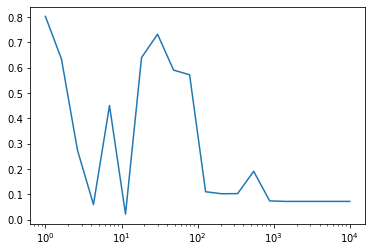

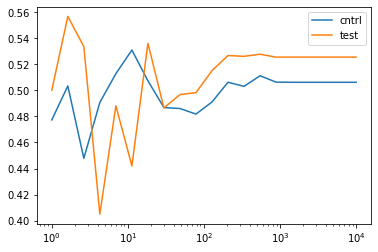

In [264]:
betas = np.logspace(0, 4, 20)
p_values = []
cntrl_metric = []
test_metric = []

for beta in tqdm(betas):
    res = process_exp('//home/voice/ilnur/tasks/EXPERIMENTS-73207/extract_result_2_portions', 
                      portion=None, calc_metric=calc_metric_avg, alpha=0, plot=False, beta=beta)
    
    p_values.append(res["p_value"])
    cntrl_metric.append(res["cntr_value"])
    test_metric.append(res["test_value"])
    
plt.plot(betas, p_values)
plt.xscale("log")
plt.show()

plt.plot(betas, cntrl_metric, label="cntrl")
plt.plot(betas, test_metric, label="test")
plt.xscale("log")
plt.legend()
plt.show()

pvalue=0.329, effect=0.044, ctrl metric = 0.482, test_metric = 0.503, cnt = 200



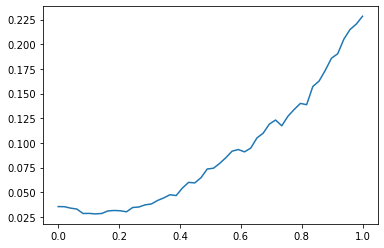

In [223]:
process_exp('//home/voice/ilnur/tasks/EXPERIMENTS-73207/extract_result_2_portions', portion=None, calc_metric=calc_metric_avg, alpha=1.0);

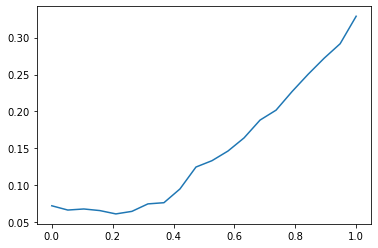

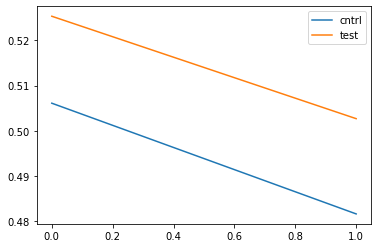

In [224]:
alphas = np.linspace(0, 1.0, 20)
p_values = []
cntrl_metric = []
test_metric = []

for alpha in alphas:
    res = process_exp('//home/voice/ilnur/tasks/EXPERIMENTS-73207/extract_result_2_portions', portion=None, calc_metric=calc_metric_avg, alpha=alpha, plot=False)
    
    p_values.append(res["p_value"])
    cntrl_metric.append(res["cntr_value"])
    test_metric.append(res["test_value"])
    
plt.plot(alphas, p_values)
plt.show()

plt.plot(alphas, cntrl_metric, label="cntrl")
plt.plot(alphas, test_metric, label="test")
plt.legend()
plt.show()

pvalue=0.046, effect=0.035, ctrl metric = 0.498, test_metric = 0.516, cnt = 200



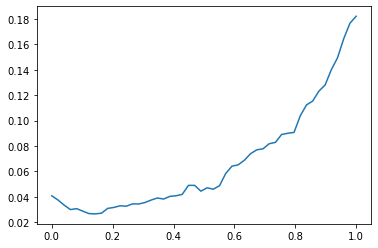

{'p_value': 0.04569136147196698,
 'cntr_value': 0.49847614073696733,
 'test_value': 0.5159803855520557}

In [225]:
process_exp('//home/voice/ilnur/tasks/EXPERIMENTS-73207/extract_result_2_portions', portion=None, calc_metric=calc_metric_raw_avg)

pvalue=0.092, effect=0.036, ctrl metric = 0.720, test_metric = 0.746, cnt = 200



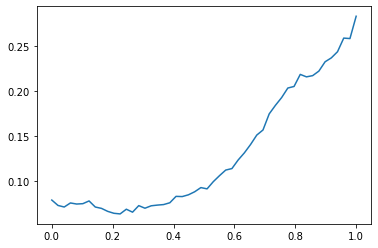

{'p_value': 0.09226246568814511,
 'cntr_value': 0.720154576086394,
 'test_value': 0.7459426048760908}

In [226]:
process_exp('//home/voice/ilnur/tasks/EXPERIMENTS-73207/extract_result_2_portions', portion=None, calc_metric=calc_metric_energy)

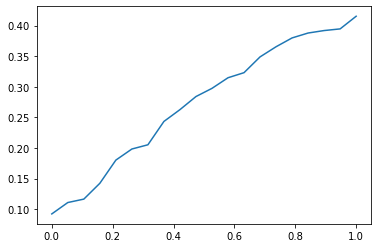

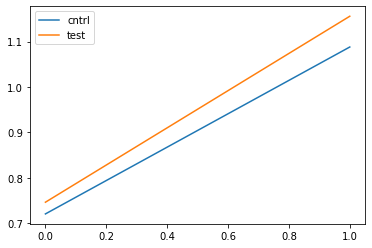

In [227]:
alphas = np.linspace(0, 1.0, 20)
p_values = []
cntrl_metric = []
test_metric = []

for alpha in alphas:
    res = process_exp('//home/voice/ilnur/tasks/EXPERIMENTS-73207/extract_result_2_portions', portion=None, calc_metric=calc_metric_energy, alpha=alpha, plot=False)
    
    p_values.append(res["p_value"])
    cntrl_metric.append(res["cntr_value"])
    test_metric.append(res["test_value"])
    
plt.plot(alphas, p_values)
plt.show()

plt.plot(alphas, cntrl_metric, label="cntrl")
plt.plot(alphas, test_metric, label="test")
plt.legend()
plt.show()

In [279]:
res = make_report_table_for_exp('//home/voice/ilnur/tasks/EXPERIMENTS-73207/extract_result_2_portions')
res.to_csv("Отключение BERT")
res

,metric,cntrl_value,test_value,diff,p_value
0,Усреднеенная метрика по сессиям,0.506094,0.525378,0.019283,0.072121
1,Усреднеенная метрика по сессиям с взвешиванием,0.481541,0.502665,0.021124,0.328998
2,Усреднеенная метрика по сессиям с семплированием,0.451365,0.449755,-0.001610,0.823840
3,Усреднеенная метрика по микро сессиям,0.498476,0.515980,0.017504,0.045691
4,Усреднеенная метрика по микро сессиям с взвеши...,0.458416,0.478877,0.020461,0.551279
5,Средняя энергия сессий,0.720155,0.745943,0.025788,0.092262
6,Средняя энергия сессий с взвешиванием,1.087939,1.155715,0.067776,0.415147
7,Средняя энергия сессий с семплированием,0.995056,1.015957,0.020901,0.577400


### External_skill_gc

In [83]:
res = make_report_table_for_exp_without_sampl('//home/voice/eliseevmax/tasks/EXPERIMENTS-73207/external_skill_gc_3/small_smart_speakers-quasar/joined_results',
                               test_name = "test_378112",
                               cntrl_name= "cntrl_378111"
                               )
res

,metric,cntrl_value,test_value,diff,p_value
0,Усреднеенная метрика по сессиям,0.438179,0.441718,0.003539,0.435681
1,Усреднеенная метрика по микро сессиям,0.437186,0.437685,0.000499,0.847852
2,Средняя энергия сессий,0.939492,0.880480,-0.059012,0.628320
3,Согласованность,0.678574,NaN,NaN,NaN


In [84]:
res = make_report_table_for_exp_without_sampl('//home/voice/eliseevmax/tasks/EXPERIMENTS-73207/external_skill_gc_3/small_smart_speakers-quasar/joined_results_dawid_skene',
                               test_name = "test_378112",
                               cntrl_name= "cntrl_378111"
                               )
res

,metric,cntrl_value,test_value,diff,p_value
0,Усреднеенная метрика по сессиям,0.428214,0.425035,-0.003179,0.838315
1,Усреднеенная метрика по микро сессиям,0.427593,0.420741,-0.006852,0.619770
2,Средняя энергия сессий,0.969494,0.884609,-0.084885,0.114559
3,Согласованность,0.748782,NaN,NaN,NaN


### Случайный семпл длинн 

In [67]:
res = make_report_table_for_exp_without_sampl('//home/voice/eliseevmax/tasks/EXPERIMENTS-73207/results_with_random_len_general_3',
                               test_name = "test_378112",
                               cntrl_name= "cntrl_378111"
                               )
res.to_csv("Отключение BERT")
res

,metric,cntrl_value,test_value,diff,p_value
0,Усреднеенная метрика по сессиям,0.556183,0.557967,0.001784,0.788009
1,Усреднеенная метрика по микро сессиям,0.546818,0.551155,0.004337,0.631399
2,Средняя энергия сессий,0.714702,0.747469,0.032767,0.683857
3,Согласованность,0.678584,NaN,NaN,NaN


In [92]:
res = make_report_table_for_exp_without_sampl('//home/voice/eliseevmax/tasks/EXPERIMENTS-73207/external_skill_gc_5/small_smart_speakers-quasar/joined_results',
                               test_name = "test_378112",
                               cntrl_name= "cntrl_378111"
                               )
res

,metric,cntrl_value,test_value,diff,p_value
0,Усреднеенная метрика по сессиям,0.460462,0.456144,-0.004318,0.929898
1,Усреднеенная метрика по микро сессиям,0.458172,0.459757,0.001585,0.750471
2,Средняя энергия сессий,1.048964,0.992613,-0.056351,0.305762
3,Согласованность,0.686143,NaN,NaN,NaN


### Dawid-Skene

In [68]:
res = make_report_table_for_exp_without_sampl('//home/voice/eliseevmax/tasks/EXPERIMENTS-73207/results_with_random_len_general_3_dawid_skene',
                               test_name = "test_378112",
                               cntrl_name= "cntrl_378111"
                               )
res.to_csv("Отключение BERT")
res

,metric,cntrl_value,test_value,diff,p_value
0,Усреднеенная метрика по сессиям,0.573561,0.563371,-0.010190,0.879411
1,Усреднеенная метрика по микро сессиям,0.561882,0.551209,-0.010673,0.931555
2,Средняя энергия сессий,0.750187,0.763796,0.013608,0.890121
3,Согласованность,0.785110,NaN,NaN,NaN


In [37]:
dawid_skene = pd.DataFrame(
    client.read_table('//home/voice/eliseevmax/tasks/EXPERIMENTS-73207/results_with_random_len_general_3_dawid_skene', raw=False)
)

mv = pd.DataFrame(
    client.read_table('//home/voice/eliseevmax/tasks/EXPERIMENTS-73207/results_with_random_len_general_3', raw=False)
)

pair_of_answers = dawid_skene.merge(
    mv, on="session_id", suffixes=["_david_skene", "_mv"]
)[["result_david_skene", "result_mv"]]

In [75]:
import plotly.graph_objects as go

cnt = Counter((pair_of_answers["result_mv"] + "_" + pair_of_answers["result_david_skene"]))


order_dict = {
    "stupid": 1,
    "bad": 2,
    "part": 3,
    "good": 4
}

x = []
y = []
size = []



for key, val in cnt.items():
    x.append(key.split("_")[0])
    y.append(key.split("_")[1])
    size.append(val)

joined = list(zip(x, y, size))

joined = sorted(joined, key = lambda x: order_dict[x[0]] * 10 + order_dict[x[1]] )

x = np.array([item[0] for item in joined])
y = np.array([item[1] for item in joined])
size = np.array([item[2] for item in joined])


fig = go.Figure(data=go.Scatter(
    x=x,
    y=y,
    mode='markers',
    marker=dict(size=size/10 + 2,
                ),
    text = size
))
layout = {
        "title" : {
            "text": "Aggregation algorithm",
        },
        "xaxis_title": "result_mv",
        "yaxis_title": "result_david_skene",
    }
fig.update_layout(layout)
fig.show()

### Минимальная длинна 5

In [70]:


res = make_report_table_for_exp_without_sampl('//home/voice/eliseevmax/tasks/EXPERIMENTS-73207/results_with_random_len_general_5',
                               test_name = "test_378112",
                               cntrl_name= "cntrl_378111"
                               )
res.to_csv("Отключение BERT")
res

,metric,cntrl_value,test_value,diff,p_value
0,Усреднеенная метрика по сессиям,0.512541,0.532351,0.019810,0.220268
1,Усреднеенная метрика по микро сессиям,0.524190,0.539966,0.015776,0.380570
2,Средняя энергия сессий,0.824601,0.848672,0.024071,0.360251
3,Согласованность,0.666103,NaN,NaN,NaN


In [71]:
res = make_report_table_for_exp_without_sampl('//home/voice/eliseevmax/tasks/EXPERIMENTS-73207/results_with_random_len_general_5_dawid_skene',
                               test_name = "test_378112",
                               cntrl_name= "cntrl_378111"
                               )
res.to_csv("Отключение BERT")
res

,metric,cntrl_value,test_value,diff,p_value
0,Усреднеенная метрика по сессиям,0.526320,0.542742,0.016423,0.207657
1,Усреднеенная метрика по микро сессиям,0.529969,0.541807,0.011838,0.224387
2,Средняя энергия сессий,0.880733,0.887579,0.006846,0.756219
3,Согласованность,0.737270,NaN,NaN,NaN


In [72]:
dawid_skene = pd.DataFrame(
    client.read_table('//home/voice/eliseevmax/tasks/EXPERIMENTS-73207/results_with_random_len_general_5_dawid_skene', raw=False)
)

mv = pd.DataFrame(
    client.read_table('//home/voice/eliseevmax/tasks/EXPERIMENTS-73207/results_with_random_len_general_5', raw=False)
)

pair_of_answers = dawid_skene.merge(
    mv, on="session_id", suffixes=["_david_skene", "_mv"]
)[["result_david_skene", "result_mv"]]

In [73]:
import plotly.graph_objects as go

cnt = Counter((pair_of_answers["result_mv"] + "_" + pair_of_answers["result_david_skene"]))


order_dict = {
    "stupid": 1,
    "bad": 2,
    "part": 3,
    "good": 4
}

x = []
y = []
size = []



for key, val in cnt.items():
    x.append(key.split("_")[0])
    y.append(key.split("_")[1])
    size.append(val)

joined = list(zip(x, y, size))

joined = sorted(joined, key = lambda x: order_dict[x[0]] * 10 + order_dict[x[1]] )

x = np.array([item[0] for item in joined])
y = np.array([item[1] for item in joined])
size = np.array([item[2] for item in joined])


fig = go.Figure(data=go.Scatter(
    x=x,
    y=y,
    mode='markers',
    marker=dict(size=size/10,
                ),
    text = size
))
layout = {
        "title" : {
            "text": "Aggregation algorithm",
        },
        "xaxis_title": "result_mv",
        "yaxis_title": "result_david_skene",
    }
fig.update_layout(layout)
fig.show()

# Гениальная болталка

In [228]:
# //home/voice/ilnur/tasks/EXPERIMENTS-81406/extract_result_2_portions

pvalue=0.026, effect=-0.037, ctrl metric = 0.595, test_metric = 0.573, cnt = 200



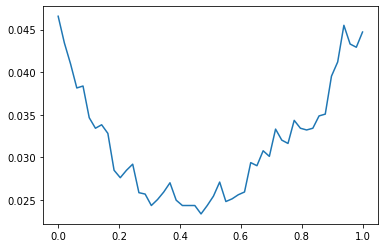

In [229]:
process_exp('//home/voice/ilnur/tasks/EXPERIMENTS-81406/extract_result_2_portions', portion=None, calc_metric=calc_metric_avg, alpha=0.0);

pvalue=0.761, effect=0.054, ctrl metric = 0.671, test_metric = 0.707, cnt = 47



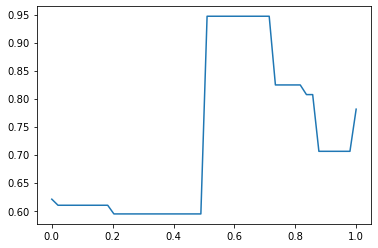

{'p_value': 0.7606924290114268,
 'cntr_value': 0.6706349206349207,
 'test_value': 0.7067307692307693}

In [267]:
process_exp('//home/voice/ilnur/tasks/EXPERIMENTS-81406/extract_result_2_portions', 
                      portion=None, calc_metric=calc_metric_avg, alpha=0, beta=1)

  0%|          | 0/20 [00:00<?, ?it/s]

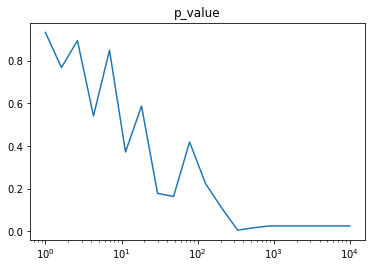

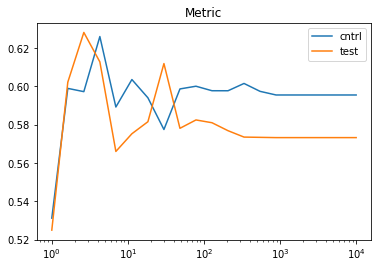

In [280]:
betas = np.logspace(0, 4, 20)
p_values = []
cntrl_metric = []
test_metric = []

for beta in tqdm(betas):
    res = process_exp('//home/voice/ilnur/tasks/EXPERIMENTS-81406/extract_result_2_portions', 
                      portion=None, calc_metric=calc_metric_avg, alpha=0, plot=False, beta=beta)
    
    p_values.append(res["p_value"])
    cntrl_metric.append(res["cntr_value"])
    test_metric.append(res["test_value"])
    
plt.title("p_value")
plt.plot(betas, p_values)
plt.xscale("log")
plt.show()

plt.title("Metric")
plt.plot(betas, cntrl_metric, label="cntrl")
plt.plot(betas, test_metric, label="test")
plt.xscale("log")
plt.legend()
plt.show()

pvalue=0.708, effect=-0.013, ctrl metric = 0.598, test_metric = 0.590, cnt = 200



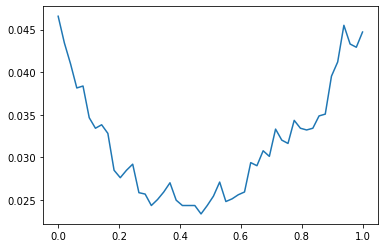

In [230]:
process_exp('//home/voice/ilnur/tasks/EXPERIMENTS-81406/extract_result_2_portions', portion=None, calc_metric=calc_metric_avg, alpha=1.0);

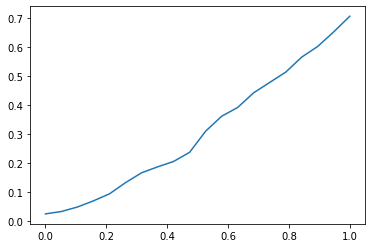

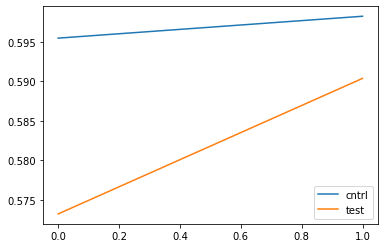

In [231]:
alphas = np.linspace(0, 1.0, 20)
p_values = []
cntrl_metric = []
test_metric = []

for alpha in alphas:
    res = process_exp('//home/voice/ilnur/tasks/EXPERIMENTS-81406/extract_result_2_portions', portion=None, calc_metric=calc_metric_avg, alpha=alpha, plot=False)
    
    p_values.append(res["p_value"])
    cntrl_metric.append(res["cntr_value"])
    test_metric.append(res["test_value"])
    
plt.plot(alphas, p_values)
plt.show()

plt.plot(alphas, cntrl_metric, label="cntrl")
plt.plot(alphas, test_metric, label="test")
plt.legend()
plt.show()

pvalue=0.008, effect=-0.037, ctrl metric = 0.591, test_metric = 0.569, cnt = 200



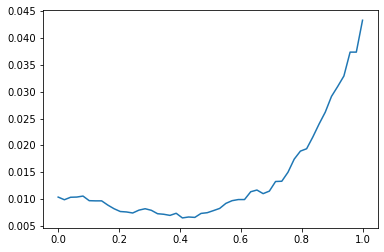

{'p_value': 0.007991730120954338,
 'cntr_value': 0.5910870402217238,
 'test_value': 0.5691503357916932}

In [232]:
process_exp('//home/voice/ilnur/tasks/EXPERIMENTS-81406/extract_result_2_portions', portion=None, calc_metric=calc_metric_raw_avg)

pvalue=0.025, effect=-0.055, ctrl metric = 0.972, test_metric = 0.919, cnt = 200



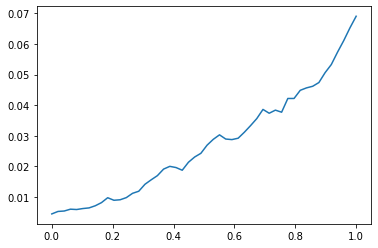

{'p_value': 0.025198356897272303,
 'cntr_value': 0.971890822489643,
 'test_value': 0.9187221514421436}

In [233]:
process_exp('//home/voice/ilnur/tasks/EXPERIMENTS-81406/extract_result_2_portions', portion=None, calc_metric=calc_metric_energy)

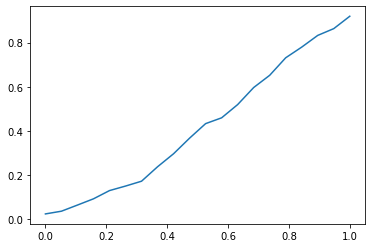

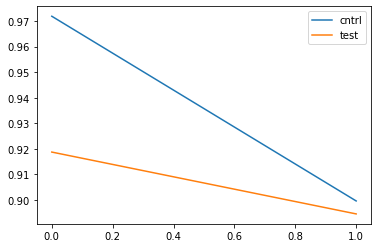

In [234]:
alphas = np.linspace(0, 1.0, 20)
p_values = []
cntrl_metric = []
test_metric = []

for alpha in alphas:
    res = process_exp('//home/voice/ilnur/tasks/EXPERIMENTS-81406/extract_result_2_portions', portion=None, calc_metric=calc_metric_energy, alpha=alpha, plot=False)
    
    p_values.append(res["p_value"])
    cntrl_metric.append(res["cntr_value"])
    test_metric.append(res["test_value"])
    
plt.plot(alphas, p_values)
plt.show()

plt.plot(alphas, cntrl_metric, label="cntrl")
plt.plot(alphas, test_metric, label="test")
plt.legend()
plt.show()

In [277]:
res = make_report_table_for_exp('//home/voice/ilnur/tasks/EXPERIMENTS-81406/extract_result_2_portions')
res.to_csv("Гениальная болталка")
res

,metric,cntrl_value,test_value,diff,p_value
0,Усреднеенная метрика по сессиям,0.595447,0.573222,-0.022224,0.026099
1,Усреднеенная метрика по сессиям с взвешиванием,0.598214,0.590358,-0.007857,0.707616
2,Усреднеенная метрика по сессиям с семплированием,0.596159,0.570129,-0.026030,0.503326
3,Усреднеенная метрика по микро сессиям,0.591087,0.569150,-0.021937,0.007992
4,Усреднеенная метрика по микро сессиям с взвеши...,0.598659,0.614480,0.015821,0.736194
5,Средняя энергия сессий,0.971891,0.918722,-0.053169,0.025198
6,Средняя энергия сессий с взвешиванием,0.899587,0.894512,-0.005075,0.919232
7,Средняя энергия сессий с семплированием,0.811404,1.002631,0.191227,0.006455


In [287]:
table_name = '//home/voice/ilnur/tasks/EXPERIMENTS-81406/extract_result_2_portions'

read_result = pd.DataFrame(client.read_table(table_name, raw=False))
read_result["is_part"] = 1 * (read_result["result"] == "part")
read_result["is_stupid"] = 1 * (read_result["result"] == "stupid")
read_result["is_good"] = 1 * (read_result["result"] == "good")
read_result["is_bad"] = 1 * (read_result["result"] == "bad")
    
    
parsed_data = read_result.groupby(by=["session_id_old"]).agg(
                                                part_cnt = pd.NamedAgg(column = 'is_part', aggfunc = 'sum'),
                                                stupid_cnt = pd.NamedAgg(column = 'is_stupid', aggfunc = 'sum'),
                                                good_cnt = pd.NamedAgg(column = 'is_good', aggfunc = 'sum'),
                                                bad_cnt = pd.NamedAgg(column = 'is_bad', aggfunc = 'sum'),
                                                test_name = pd.NamedAgg(column = 'test_name', aggfunc = 'last'),
                                                uuid = pd.NamedAgg(column = 'uuid', aggfunc = 'last'),
                                                portion = pd.NamedAgg(column = 'portion', aggfunc = 'last'),
                                                frequency = pd.NamedAgg(column = 'frequency', aggfunc = 'mean'),
                                                session_len = pd.NamedAgg(column = 'session_len', aggfunc = 'last'),
                                                ).reset_index()

In [288]:
read_result

,frequency,portion,result,session_id_old,session_len,target_scenario,target_scenario_rounded,test_name,uuid,is_part,is_stupid,is_good,is_bad
0,5040,portion1,good,uu/7ea02c00a3913ef539db2e39ab3c902f_1633677712...,21,12,12,ctrl,uu/7ea02c00a3913ef539db2e39ab3c902f,0,0,1,0
1,5040,portion1,part,uu/7ea02c00a3913ef539db2e39ab3c902f_1633677712...,21,12,12,ctrl,uu/7ea02c00a3913ef539db2e39ab3c902f,1,0,0,0
2,8995,portion1,good,uu/7ea1e9ea3140521765bef60b8277ac86_1633593559...,10,9,9,ctrl,uu/7ea1e9ea3140521765bef60b8277ac86,0,0,1,0
3,8995,portion1,bad,uu/7eb5500f5a8d3922e38e932665659d34_1634214096...,16,9,9,ctrl,uu/7eb5500f5a8d3922e38e932665659d34,0,0,0,1
4,7540,portion1,part,uu/7ebbffc83da116a89337e62840e8a907_1633517078...,15,10,10,test,uu/7ebbffc83da116a89337e62840e8a907,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9885,3684,portion1,part,uu/7e7d76b5e6b96d2ae47452ef62e26256_1633713075...,18,14,14,ctrl,uu/7e7d76b5e6b96d2ae47452ef62e26256,1,0,0,0
9886,3684,portion1,bad,uu/7e7d76b5e6b96d2ae47452ef62e26256_1633713075...,18,14,14,ctrl,uu/7e7d76b5e6b96d2ae47452ef62e26256,0,0,0,1
9887,27214,portion1,part,uu/7e8210b1137a688eb4e3bed05005f68e_1633199828...,12,5,5,test,uu/7e8210b1137a688eb4e3bed05005f68e,1,0,0,0
9888,19711,portion1,good,uu/7e896646f6d4c33bc453f29030e30958_1633865173...,13,6,6,ctrl,uu/7e896646f6d4c33bc453f29030e30958,0,0,1,0


# Дроп интересности на проде

pvalue=0.199, effect=0.023, ctrl metric = 0.717, test_metric = 0.733, cnt = 200



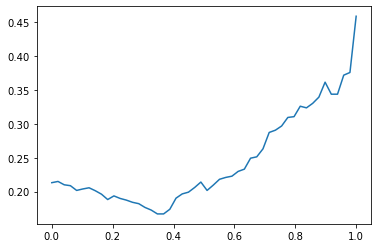

{'p_value': 0.1987059369095845,
 'cntr_value': 0.7167270202466389,
 'test_value': 0.7332091619853673}

In [62]:
process_exp('//home/voice/eliseevmax/tasks/EXPERIMENTS-97773/results_with_uniform_len',
            portion=None, 
            plot=True,
            calc_metric=calc_metric_avg,
           test_name="test_571522",
           cntrl_name="cntrl_571519",
           probability_threshold=0.0)

pvalue=0.676, effect=0.006, ctrl metric = 0.717, test_metric = 0.721, cnt = 200



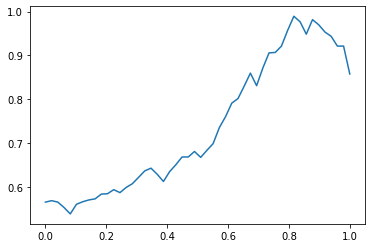

{'p_value': 0.6760716456258578,
 'cntr_value': 0.7167270202466389,
 'test_value': 0.7212803880573105}

In [76]:
process_exp('//home/voice/eliseevmax/tasks/EXPERIMENTS-97773/results_with_uniform_len',
            portion=None, 
            plot=True,
            calc_metric=calc_metric_avg,
           test_name="test_571520",
           cntrl_name="cntrl_571519",
           probability_threshold=0.0)

pvalue=0.774, effect=0.005, ctrl metric = 0.717, test_metric = 0.720, cnt = 200



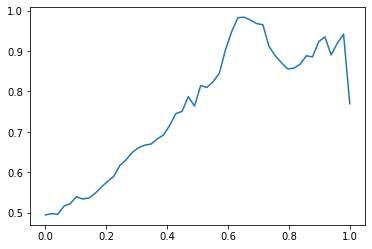

{'p_value': 0.7740307869948482,
 'cntr_value': 0.7167270202466389,
 'test_value': 0.7200774376657584}

In [64]:
process_exp('//home/voice/eliseevmax/tasks/EXPERIMENTS-97773/results_with_uniform_len',
            portion=None, 
            plot=True,
            calc_metric=calc_metric_avg,
           test_name="test_571521",
           cntrl_name="cntrl_571519",
           probability_threshold=0.0)

In [77]:
res = make_report_table_for_exp('//home/voice/eliseevmax/tasks/EXPERIMENTS-97773/results_with_uniform_len', test_name="test_571520",
           cntrl_name="cntrl_571519",)
res

,metric,cntrl_value,test_value,diff,p_value
0,Усреднеенная метрика по сессиям,0.716727,0.721280,0.004553,0.676072
1,Усреднеенная метрика по сессиям с взвешиванием,0.732637,0.729355,-0.003282,0.907604
2,Усреднеенная метрика по сессиям с семплированием,0.711574,0.745881,0.034307,0.529935
3,Усреднеенная метрика по микро сессиям,0.707758,0.713938,0.006180,0.520392
4,Усреднеенная метрика по микро сессиям с взвеши...,0.736101,0.672631,-0.063470,0.520077
5,Средняя энергия сессий,1.258197,1.298258,0.040061,0.974656
6,Средняя энергия сессий с взвешиванием,1.345980,1.306148,-0.039832,0.419355
7,Средняя энергия сессий с семплированием,1.383013,1.218553,-0.164459,0.528111


In [78]:
res = make_report_table_for_exp('//home/voice/eliseevmax/tasks/EXPERIMENTS-97773/results_with_uniform_len', test_name="test_571521",
           cntrl_name="cntrl_571519",)
res

,metric,cntrl_value,test_value,diff,p_value
0,Усреднеенная метрика по сессиям,0.716727,0.720077,0.003350,0.774031
1,Усреднеенная метрика по сессиям с взвешиванием,0.732637,0.734007,0.001369,0.516520
2,Усреднеенная метрика по сессиям с семплированием,0.692978,0.725116,0.032137,0.259445
3,Усреднеенная метрика по микро сессиям,0.707758,0.718720,0.010962,0.281694
4,Усреднеенная метрика по микро сессиям с взвеши...,0.751126,0.724305,-0.026821,0.614962
5,Средняя энергия сессий,1.258197,1.260474,0.002277,0.867056
6,Средняя энергия сессий с взвешиванием,1.345980,1.253386,-0.092594,0.226949
7,Средняя энергия сессий с семплированием,1.220370,1.046528,-0.173843,0.101022


In [79]:
res = make_report_table_for_exp('//home/voice/eliseevmax/tasks/EXPERIMENTS-97773/results_with_uniform_len', test_name="test_571522",
           cntrl_name="cntrl_571519",)
res

,metric,cntrl_value,test_value,diff,p_value
0,Усреднеенная метрика по сессиям,0.716727,0.733209,0.016482,0.198706
1,Усреднеенная метрика по сессиям с взвешиванием,0.732637,0.749793,0.017156,0.415147
2,Усреднеенная метрика по сессиям с семплированием,0.724096,0.749794,0.025698,0.665870
3,Усреднеенная метрика по микро сессиям,0.707758,0.725117,0.017359,0.090780
4,Усреднеенная метрика по микро сессиям с взвеши...,0.746247,0.754666,0.008419,0.828652
5,Средняя энергия сессий,1.258197,1.270145,0.011948,0.925040
6,Средняя энергия сессий с взвешиванием,1.345980,1.185573,-0.160407,0.051343
7,Средняя энергия сессий с семплированием,1.259058,1.337963,0.078905,0.560238


# Дроп интересности на проде с рандомным семплом

pvalue=0.273, effect=-0.016, ctrl metric = 0.684, test_metric = 0.673, cnt = 200



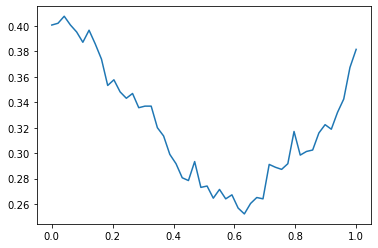

{'p_value': 0.2731244337905946,
 'cntr_value': 0.6840050833179173,
 'test_value': 0.6727235906869731}

In [65]:
process_exp('//home/voice/eliseevmax/tasks/EXPERIMENTS-97773/results_with_random_len',
            portion=None, 
            plot=True,
            calc_metric=calc_metric_avg,
           test_name="test_571522",
           cntrl_name="cntrl_571519",
           probability_threshold=0.0)

pvalue=0.849, effect=-0.003, ctrl metric = 0.684, test_metric = 0.682, cnt = 200



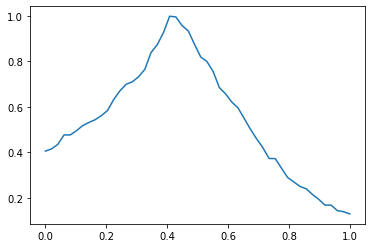

{'p_value': 0.8488469533777628,
 'cntr_value': 0.6840050833179173,
 'test_value': 0.6818228867559694}

In [66]:
process_exp('//home/voice/eliseevmax/tasks/EXPERIMENTS-97773/results_with_random_len',
            portion=None, 
            plot=True,
            calc_metric=calc_metric_avg,
           test_name="test_571520",
           cntrl_name="cntrl_571519",
           probability_threshold=0.0)

pvalue=0.245, effect=-0.018, ctrl metric = 0.684, test_metric = 0.671, cnt = 200



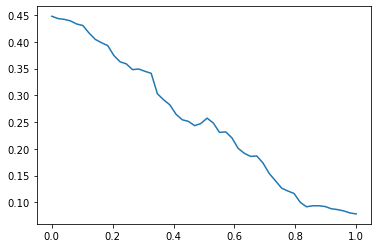

{'p_value': 0.24529439133794184,
 'cntr_value': 0.6840050833179173,
 'test_value': 0.6713794057760226}

In [67]:
process_exp('//home/voice/eliseevmax/tasks/EXPERIMENTS-97773/results_with_random_len',
            portion=None, 
            plot=True,
            calc_metric=calc_metric_avg,
           test_name="test_571521",
           cntrl_name="cntrl_571519",
           probability_threshold=0.0)

In [80]:
res = make_report_table_for_exp('//home/voice/eliseevmax/tasks/EXPERIMENTS-97773/results_with_random_len', test_name="test_571520",
           cntrl_name="cntrl_571519",)
res

,metric,cntrl_value,test_value,diff,p_value
0,Усреднеенная метрика по сессиям,0.684005,0.681823,-0.002182,0.848847
1,Усреднеенная метрика по сессиям с взвешиванием,0.690125,0.694703,0.004577,0.956157
2,Усреднеенная метрика по сессиям с семплированием,0.717022,0.675189,-0.041833,0.243625
3,Усреднеенная метрика по микро сессиям,0.669590,0.668666,-0.000924,0.858414
4,Усреднеенная метрика по микро сессиям с взвеши...,0.668285,0.674115,0.005830,0.960567
5,Средняя энергия сессий,0.887266,0.903459,0.016193,0.392372
6,Средняя энергия сессий с взвешиванием,0.823069,0.854775,0.031706,0.087876
7,Средняя энергия сессий с семплированием,0.835759,0.821820,-0.013939,0.970483


In [81]:
res = make_report_table_for_exp('//home/voice/eliseevmax/tasks/EXPERIMENTS-97773/results_with_random_len', test_name="test_571521",
           cntrl_name="cntrl_571519",)
res

,metric,cntrl_value,test_value,diff,p_value
0,Усреднеенная метрика по сессиям,0.684005,0.671379,-0.012626,0.245294
1,Усреднеенная метрика по сессиям с взвешиванием,0.690125,0.689013,-0.001112,0.909541
2,Усреднеенная метрика по сессиям с семплированием,0.704426,0.649106,-0.055320,0.189638
3,Усреднеенная метрика по микро сессиям,0.669590,0.658558,-0.011032,0.242714
4,Усреднеенная метрика по микро сессиям с взвеши...,0.714572,0.714110,-0.000462,0.855406
5,Средняя энергия сессий,0.887266,0.866370,-0.020896,0.560006
6,Средняя энергия сессий с взвешиванием,0.823069,0.802537,-0.020532,0.713075
7,Средняя энергия сессий с семплированием,0.799691,0.734223,-0.065469,0.555850


In [82]:
res = make_report_table_for_exp('//home/voice/eliseevmax/tasks/EXPERIMENTS-97773/results_with_random_len', test_name="test_571522",
           cntrl_name="cntrl_571519",)
res

,metric,cntrl_value,test_value,diff,p_value
0,Усреднеенная метрика по сессиям,0.684005,0.672724,-0.011281,0.273124
1,Усреднеенная метрика по сессиям с взвешиванием,0.690125,0.690377,0.000252,0.973686
2,Усреднеенная метрика по сессиям с семплированием,0.656301,0.695389,0.039087,0.391741
3,Усреднеенная метрика по микро сессиям,0.669590,0.667772,-0.001818,0.868020
4,Усреднеенная метрика по микро сессиям с взвеши...,0.717944,0.731253,0.013309,0.700922
5,Средняя энергия сессий,0.887266,0.867457,-0.019809,0.356933
6,Средняя энергия сессий с взвешиванием,0.823069,0.798515,-0.024554,0.601905
7,Средняя энергия сессий с семплированием,0.810000,0.686809,-0.123191,0.177354


In [7]:
res = make_report_table_for_exp(
    '//home/voice/eliseevmax/tasks/EXPERIMENTS-97773/results_with_random_len', 
    test_name="test_571520",
           cntrl_name="cntrl_571519",)
res

,metric,cntrl_value,test_value,diff,p_value
0,Усреднеенная метрика по сессиям,0.684587,0.678365,-0.006222,0.420756
1,Усреднеенная метрика по сессиям с взвешиванием,0.692766,0.694559,0.001793,0.751685
2,Усреднеенная метрика по сессиям с семплированием,0.724537,0.736517,0.011980,0.757823
3,Усреднеенная метрика по микро сессиям,0.667879,0.664430,-0.003449,0.642420
4,Усреднеенная метрика по микро сессиям с взвеши...,0.667989,0.729311,0.061322,0.128530
5,Средняя энергия сессий,0.887109,0.899360,0.012252,0.948367
6,Средняя энергия сессий с взвешиванием,0.825889,0.854749,0.028860,0.169316
7,Средняя энергия сессий с семплированием,0.827814,0.824038,-0.003775,0.268836


In [6]:
res = make_report_table_for_exp(
    '//home/voice/eliseevmax/tasks/EXPERIMENTS-97773/results_with_random_len', 
    test_name="test_571521",
           cntrl_name="cntrl_571519",)
res

,metric,cntrl_value,test_value,diff,p_value
0,Усреднеенная метрика по сессиям,0.684587,0.671617,-0.012971,0.122235
1,Усреднеенная метрика по сессиям с взвешиванием,0.692766,0.693330,0.000564,0.845981
2,Усреднеенная метрика по сессиям с семплированием,0.684384,0.731352,0.046968,0.369931
3,Усреднеенная метрика по микро сессиям,0.667879,0.660588,-0.007291,0.344303
4,Усреднеенная метрика по микро сессиям с взвеши...,0.659570,0.703921,0.044352,0.177741
5,Средняя энергия сессий,0.887109,0.866374,-0.020735,0.261475
6,Средняя энергия сессий с взвешиванием,0.825889,0.807324,-0.018565,0.524449
7,Средняя энергия сессий с семплированием,0.728333,0.863134,0.134801,0.058534


In [5]:
res = make_report_table_for_exp(
    '//home/voice/eliseevmax/tasks/EXPERIMENTS-97773/results_with_random_len_general_4', 
    test_name="test_571522",
           cntrl_name="cntrl_571519",)
res

,metric,cntrl_value,test_value,diff,p_value
0,Усреднеенная метрика по сессиям,0.619909,0.625116,0.005207,0.341869
1,Усреднеенная метрика по сессиям с взвешиванием,0.619185,0.625909,0.006724,0.861314
2,Усреднеенная метрика по сессиям с семплированием,0.636382,0.596400,-0.039982,0.226188
3,Усреднеенная метрика по микро сессиям,0.611631,0.621090,0.009459,0.077910
4,Усреднеенная метрика по микро сессиям с взвеши...,0.636283,0.638599,0.002316,0.931082
5,Средняя энергия сессий,1.008389,0.995935,-0.012454,0.553492
6,Средняя энергия сессий с взвешиванием,1.122390,1.079044,-0.043347,0.158228
7,Средняя энергия сессий с семплированием,1.283824,1.062140,-0.221684,0.131367


# Уменьшение глубины контекста

In [76]:
# Контекст 1
res = make_report_table_for_exp_without_sampl(
    '//home/voice/eliseevmax/tasks/EXPERIMENTS-99465/general_conversation_3_len/small_smart_speakers-quasar/joined_results', 
    test_name="test_583842",
           cntrl_name="cntrl_583841",)
res

2022-05-27 08:19:45,270	WARNING	HTTP GET request http://hahn.yt.yandex.net/api/v3/get failed with error ConnectionError(ProtocolError('Connection aborted.', OSError(65, 'No route to host'))) (request_id: df6d6ea4)
2022-05-27 08:19:45,280	WARNING	Sleep for 4.40 seconds before next retry (request_id: df6d6ea4)
2022-05-27 08:19:49,680	WARNING	New retry (2) for request id df6d6ea4...
2022-05-27 08:20:09,875	WARNING	HTTP POST request http://hahn.yt.yandex.net/api/v3/lock failed with error ReadTimeout(ReadTimeoutError("HTTPConnectionPool(host='hahn.yt.yandex.net', port=80): Read timed out. (read timeout=20.0)")) (request_id: 1090e10f)
2022-05-27 08:20:09,876	WARNING	Sleep for 4.65 seconds before next retry (request_id: 1090e10f)
2022-05-27 08:20:14,532	WARNING	New retry (2) for request id 1090e10f...


,metric,cntrl_value,test_value,diff,p_value
0,Усреднеенная метрика по сессиям,0.653807,0.591576,-0.062230,0.391799
1,Усреднеенная метрика по микро сессиям,0.632033,0.591287,-0.040746,0.642309
2,Средняя энергия сессий,0.712284,0.664312,-0.047972,0.610066
3,Согласованность,0.700342,NaN,NaN,NaN


In [77]:
# Контекст 3
res = make_report_table_for_exp_without_sampl(
    '//home/voice/eliseevmax/tasks/EXPERIMENTS-99465/general_conversation_3_len/small_smart_speakers-quasar/joined_results', 
    test_name="test_583846",
           cntrl_name="cntrl_583841",)
res

,metric,cntrl_value,test_value,diff,p_value
0,Усреднеенная метрика по сессиям,0.653807,0.587056,-0.066751,0.362721
1,Усреднеенная метрика по микро сессиям,0.632033,0.582105,-0.049928,0.610502
2,Средняя энергия сессий,0.712284,0.687056,-0.025228,0.400765
3,Согласованность,0.700342,NaN,NaN,NaN


In [78]:
# Контекст 5
res = make_report_table_for_exp_without_sampl(
    '//home/voice/eliseevmax/tasks/EXPERIMENTS-99465/general_conversation_3_len/small_smart_speakers-quasar/joined_results', 
    test_name="test_583847",
           cntrl_name="cntrl_583841",)
res

,metric,cntrl_value,test_value,diff,p_value
0,Усреднеенная метрика по сессиям,0.653807,0.542262,-0.111545,0.203869
1,Усреднеенная метрика по микро сессиям,0.632033,0.532431,-0.099602,0.259172
2,Средняя энергия сессий,0.712284,0.634524,-0.077760,0.366836
3,Согласованность,0.700342,NaN,NaN,NaN


### Dawid-Skene

In [80]:
# Контекст 1
res = make_report_table_for_exp_without_sampl(
    test_name="test_583842",
           cntrl_name="cntrl_583841",)
res

,metric,cntrl_value,test_value,diff,p_value
0,Усреднеенная метрика по сессиям,0.708318,0.678390,-0.029928,0.258668
1,Усреднеенная метрика по микро сессиям,0.693052,0.677855,-0.015197,0.465546
2,Средняя энергия сессий,0.896512,0.818537,-0.077975,0.544300
3,Согласованность,0.855360,NaN,NaN,NaN


In [81]:
# Контекст 3
res = make_report_table_for_exp_without_sampl(
    '//home/voice/eliseevmax/tasks/EXPERIMENTS-99465/general_conversation_3_len/small_smart_speakers-quasar/joined_results_dawid_skene', 
    test_name="test_583846",
           cntrl_name="cntrl_583841",)
res

,metric,cntrl_value,test_value,diff,p_value
0,Усреднеенная метрика по сессиям,0.708318,0.630918,-0.077400,0.067942
1,Усреднеенная метрика по микро сессиям,0.693052,0.637889,-0.055163,0.186555
2,Средняя энергия сессий,0.896512,0.789812,-0.106700,0.066089
3,Согласованность,0.855360,NaN,NaN,NaN


In [82]:
# Контекст 5
res = make_report_table_for_exp_without_sampl(
    '//home/voice/eliseevmax/tasks/EXPERIMENTS-99465/general_conversation_3_len/small_smart_speakers-quasar/joined_results_dawid_skene', 
    test_name="test_583847",
           cntrl_name="cntrl_583841",)
res

,metric,cntrl_value,test_value,diff,p_value
0,Усреднеенная метрика по сессиям,0.708318,0.667696,-0.040621,0.431274
1,Усреднеенная метрика по микро сессиям,0.693052,0.661090,-0.031963,0.583890
2,Средняя энергия сессий,0.896512,0.891088,-0.005424,0.574034
3,Согласованность,0.855360,NaN,NaN,NaN
